In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
import os

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  

# os.environ['OPENBLAS_NUM_THREADS'] = '1'

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

#env: lpr

In [2]:
events = NanoEventsFactory.from_root(
    # '/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/TTJets/TTJets/merged_2.root',
    '/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/QCD/QCD_HT1000to1500/merged_2.root',
).events()

events = events[ak.num(events.FatJet) >= 1]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

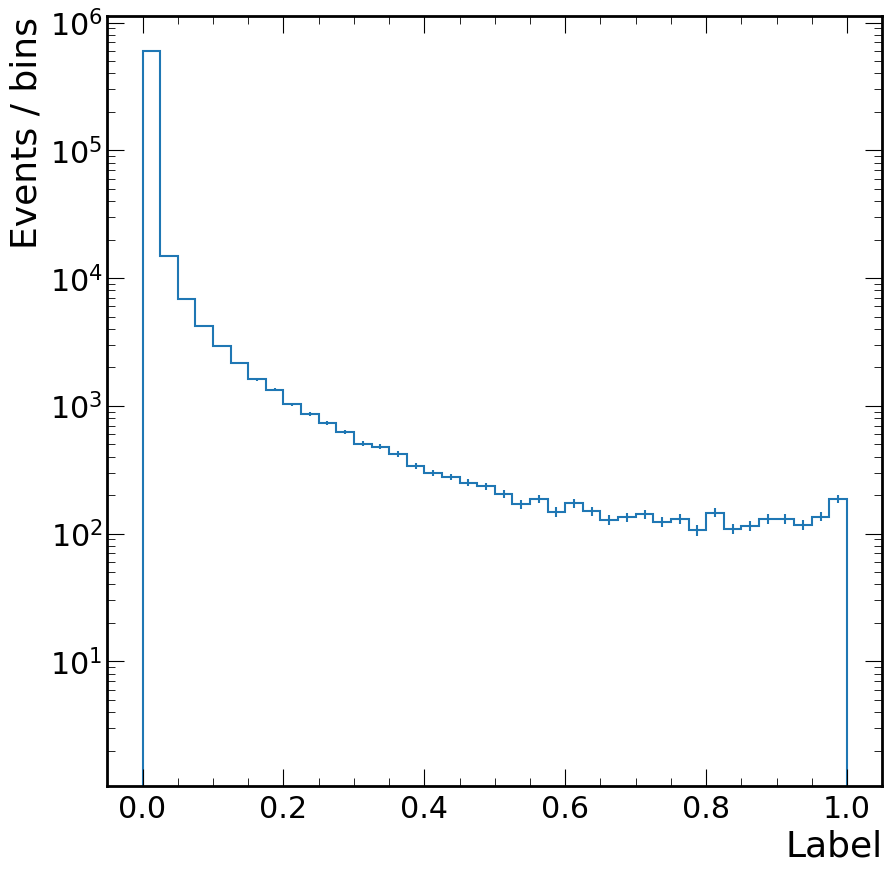

In [4]:
f, ax = plt.subplots(figsize=(10,10))

nbin, xmin, xmax = 40, 0, 1
hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
discr = f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
tagger_arr = ak.numexpr.evaluate(discr, events[ak.num(events.FatJet) >= 1].FatJet[:, 0])
hist.fill(tagger_arr[~np.isnan(tagger_arr)])
# hist.fill(arr_clean)
# 

content, yerr = hist.view().value, np.sqrt(hist.view().variance)
ax.set_yscale("log")
hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr)
ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);


In [3]:
num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
discr = f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
arr = ak.numexpr.evaluate(discr, events[ak.num(events.FatJet) >= 1].FatJet[:, 0])
print("mis-tag rate:0.001")
print(np.quantile(arr[~np.isnan(arr)], q=0.999))
print("mis-tag rate:0.01")
print(np.quantile(arr[~np.isnan(arr)], q=0.99))
print("mis-tag rate:0.05")
print(np.quantile(arr[~np.isnan(arr)], q=0.95))
print("mis-tag rate:0.1")
print(np.quantile(arr[~np.isnan(arr)], q=0.9))

mis-tag rate:0.001
0.8868183310031746
mis-tag rate:0.01
0.2703690445423127
mis-tag rate:0.05
0.04077542573213527
mis-tag rate:0.1
0.012507975660264493


In [8]:
def pad_val(
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret

### processing

In [10]:
from coffea import processor, hist
from functools import partial

class TblNodeAnalyzeProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset = hist.Cat("dataset", "dataset")

        self._accumulator = processor.dict_accumulator({
            # defination of cutflow (nested dictionary of int) copied from the example
            'cutflow': processor.defaultdict_accumulator(
                partial(processor.defaultdict_accumulator, int)
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        out = self.accumulator.identity()
        dataset = events.metadata['dataset']
        out['cutflow'][dataset]['all'] += len(events)

        fname = f"coffea_output/{dataset}/{events.metadata['filename'].split('/')[-1].replace('.root','')}_{int(events.metadata['entrystop'])}.root"

        
        #at least one AK8 jets
        events = events[ak.num(events.FatJet) >= 1]
        
        # lepton selection
        lep_sel = (ak.num(events.Electron) + ak.num(events.Muon) == 1) & (ak.num(events.Jet) >= 2) & (ak.num(events.FatJet) >= 1)
        events = events[lep_sel]
        
        # the lepton object
        lep = ak.concatenate([events.Electron, events.Muon], axis=1)[:, 0]
        lep_isel = ak.num(events.Electron) > 0

        # jet and MET selection
        jet_sel = (events.Jet.pt[:, 0] > 50) & (events.Jet.pt[:, 1] > ak.where(lep_isel, 40, 50))
        jet_btagsel = ak.num(events.Jet[events.Jet.btagDeepFlavB > 0.3040]) >= 1 # MP in 2017 deepjet, https://btv-wiki.docs.cern.ch/ScaleFactors/UL2017/#ak4-b-tagging

        met_sel = events.MET.pt > ak.where(lep_isel, 60, 70)

        # fatjet selection
        fatjet = events.FatJet[:, 0]
        fatjet_sel = (fatjet.pt > 400) & (fatjet.msoftdrop > 105) & (fatjet.msoftdrop < 210)

        # fatjet top-tagging discr. We use ParT (MD) to construct the t->bqq discr and manually cut at 1% mistag WP
        num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
        discr = f'({num}) / ({num} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
        fatjet_toptagsel = ak.numexpr.evaluate(discr, fatjet) > 0.79 # 1% mistag rate on QCD

        # selection based on all objects
        # sel = jet_sel & jet_btagsel & met_sel & fatjet_sel & fatjet_toptagsel
        sel = jet_sel & jet_btagsel & met_sel # let's remove the fatjet sel for now
        events = events[sel]

        # ==== Now we finished all selections ====

        # define objects
        fj1 = events.FatJet[:, 0]
        fj2 = events.mask[ak.num(events.FatJet) >= 2].FatJet[:, 1] # use mask since a second fj may not exist

        jets = events.Jet
        lep = ak.concatenate([events.Electron, events.Muon], axis=1)[:, 0]
        lep_isel = ak.num(events.Electron) > 0

        # t->bqq discr
        num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
        fj1_ParTV1_discr_bqqvsQCD = ak.numexpr.evaluate(f'({num}) / ({num} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj1)
        
        # t->bl discr
        num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
        num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
        fj1_ParTV1_discr_blvsQCD = ak.numexpr.evaluate(f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj1)
        fj2_ParTV1_discr_blvsQCD = ak.numexpr.evaluate(f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj2)
        fj2_ParTV1_discr_bellvsQCD = ak.numexpr.evaluate(f'({num_bell}) / ({num_bell} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj2)

        # the 2D reconstruction workflow

        pair = ak.cartesian([lep, jets[jets.pt > 15]]) # all lep-jet pair with jet pt > 15
        dr_pair = pair['1'].delta_r(pair['0'])
        mindr_ind = ak.singletons(ak.argmin(dr_pair, axis=1))

        jet_closest = pair['1'][mindr_ind][:, 0]
        mindr = dr_pair[mindr_ind][:, 0]

        ptrel = lep.pt * np.abs(np.sin(lep.phi - jet_closest.phi)) # lep pt *perpendicular* to jet axis

        # construct output variables
        output = {}
        output['fj1_pt'] = fj1.pt
        output['fj1_eta'] = fj1.eta
        output['fj1_phi'] = fj1.phi
        output['fj1_sdmass'] = fj1.msoftdrop
        output['fj2_pt'] = ak.fill_none(fj2.pt, 0)
        output['fj2_eta'] = ak.fill_none(fj2.eta, 0)
        output['fj2_phi'] = ak.fill_none(fj2.phi, 0)
        output['fj2_sdmass'] = ak.fill_none(fj2.msoftdrop, 0)

        output['fj1_ParTV1_discr_bqqvsQCD'] = ak.fill_none(fj1_ParTV1_discr_bqqvsQCD, 0)
        output['fj1_ParTV1_discr_blvsQCD'] = ak.fill_none(fj1_ParTV1_discr_blvsQCD, 0)
        output['fj2_ParTV1_discr_blvsQCD'] = ak.fill_none(fj2_ParTV1_discr_blvsQCD, 0)
        output['fj2_ParTV1_discr_bellvsQCD'] = ak.fill_none(fj2_ParTV1_discr_bellvsQCD, 0)

        output['dr_fj12'] = ak.fill_none(fj1.delta_r(fj2), -1)

        output['lep_pt'] = lep.pt
        output['lep_eta'] = lep.eta
        output['lep_phi'] = lep.phi
        output['lep_isel'] = lep_isel
        output['lep_mindr_jet'] = mindr
        output['lep_ptrel_jet'] = ptrel

        output['deta_jet12'] = jets[:, 0].eta - jets[:, 1].eta

        # store root
        print(fname)
        os.makedirs(os.path.dirname(fname), exist_ok=True)
        with uproot.recreate(fname) as fout:
            output_root = {}
            for bname in output.keys():
                if not output[bname].fields:
                    output_root[bname] = ak.packed(ak.without_parameters(output[bname]))
                else:
                    b_nest = {}
                    for n in output[bname].fields:
                        b_nest[n] = ak.packed(ak.without_parameters(output[bname][n]))
                    output_root[bname] = ak.zip(b_nest)
            fout["tree"] = output_root

        out['cutflow'][dataset]['passed'] += len(events)
        return out
    
    def postprocess(self, accumulator):
        return accumulator

/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [11]:
import glob
fileset = {
    # 'ttbar': glob.glob('/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/TTJets/TTJets/*0.root'),
    'qcd': glob.glob('/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/QCD/QCD_HT1000to1500/*.root'),
}

In [12]:
result = processor.run_uproot_job(
    fileset=fileset,
    treename="Events",
    processor_instance=TblNodeAnalyzeProcessor(),
    executor=processor.futures_executor,
    executor_args={"schema": NanoAODSchema, "workers": 60},
)

/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

coffea_output/qcd/merged_6_233826.root
coffea_output/qcd/merged_6_116913.root
coffea_output/qcd/merged_2_427596.root
coffea_output/qcd/merged_2_534495.root
coffea_output/qcd/merged_2_641389.root
coffea_output/qcd/merged_2_320697.root
coffea_output/qcd/merged_2_106899.root
coffea_output/qcd/merged_2_213798.root
coffea_output/qcd/merged_5_104768.root
coffea_output/qcd/merged_5_628603.root
coffea_output/qcd/merged_5_314304.root
coffea_output/qcd/merged_5_209536.root
coffea_output/qcd/merged_5_419072.root
coffea_output/qcd/merged_5_523840.root
coffea_output/qcd/merged_0_507075.root
coffea_output/qcd/merged_0_405660.root
coffea_output/qcd/merged_0_101415.root
coffea_output/qcd/merged_0_202830.rootcoffea_output/qcd/merged_0_304245.root
coffea_output/qcd/merged_0_608489.root

coffea_output/qcd/merged_4_95957.root
coffea_output/qcd/merged_4_287871.root
coffea_output/qcd/merged_4_575742.root
coffea_output/qcd/merged_4_383828.root
coffea_output/qcd/merged_4_191914.root
coffea_output/qcd/merged_4